# Εργασία 8 - ANN

**Imports**

In [11]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from PIL import Image
import os
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
import tensorflow as tf
import random

## 1. Κατεβάστε το “Dog Breed Image Dataset” από το Kaggle και φορτώστε το στο Google Colab (χωρίς να το κάνετε unzip). Θα πρέπει να χει ονομασία “archive.zip”

*Done*

## 2. Εκτελέστε την εντολή “!unzip archive.zip” για να αποσυμπιέσετε τα δεδομένα.


In [12]:
# !unzip archive.zip

## 3. Στη συνέχεια, φορτώσετε τις εικόνες σε numpy arrays: Κάθε εικόνα φορτώνεται ως RGB και μετατρέπεται σε εικόνα 64x64 (για λόγους ταχύτητας και μνήμης)! Τα target αριθμούνται ανάλογα με την κατηγορία και στη συνέχεια μετατρέπονται σε one-hot vectors.


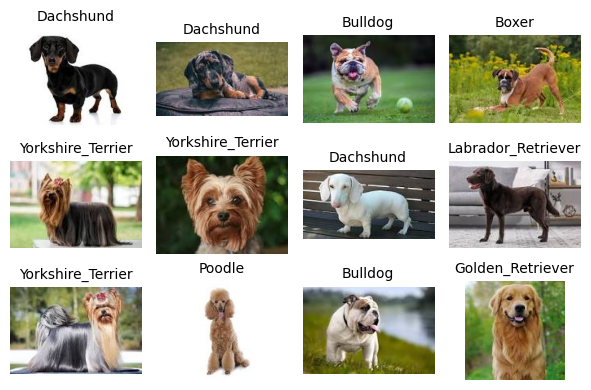

In [13]:
def show_random_images(dataset_root: str, n: int = 12, seed: int = 0):
    root = Path(dataset_root)
    rng = random.Random(seed)

    class_dirs = sorted([p for p in root.iterdir() if p.is_dir()])
    items = []
    for d in class_dirs:
        jpgs = list(d.glob("*.jpg"))
        items.extend([(p, d.name) for p in jpgs])

    picks = rng.sample(items, k=min(n, len(items)))

    cols = 4
    rows = (len(picks) + cols - 1) // cols
    plt.figure(figsize=(6, 4))

    for i, (img_path, label) in enumerate(picks, start=1):
        im = Image.open(img_path).convert("RGB")
        plt.subplot(rows, cols, i)
        plt.imshow(im)
        plt.title(label, fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Χρηση
show_random_images(r"dataset", n=12, seed=41)

In [14]:
def load_images_64x64_numpy(dataset_root: str, img_size=(64, 64), normalize=True):
    """
    Περιμενει δομη: dataset_root/<class_name>/*.jpg
    Επιστρεφει:
      X: (N,64,64,3) float32 αν normalize αλλιως uint8
      y: (N,) int64
      class_names: list[str]
      class_to_idx: dict[str,int]
    """
    root = Path(dataset_root)
    class_dirs = sorted([p for p in root.iterdir() if p.is_dir()], key=lambda p: p.name.lower())

    class_names = [d.name for d in class_dirs]
    class_to_idx = {name: i for i, name in enumerate(class_names)}

    # 1) Gather paths + labels
    paths = []
    labels = []
    for d in class_dirs:
        lbl = class_to_idx[d.name]
        for p in d.glob("*.jpg"):
            paths.append(p)
            labels.append(lbl)

    N = len(paths)

    # 2) Preallocate
    X = np.empty((N, img_size[1], img_size[0], 3), dtype=np.uint8)  # (N,H,W,3)
    y = np.asarray(labels, dtype=np.int64)

    # 3) Load + resize
    # PIL resampling: νεοτερες εκδοσεις εχουν Image.Resampling.BILINEAR
    resample = Image.Resampling.BILINEAR

    for i, p in enumerate(paths):
        with Image.open(p) as im:
            im = im.convert("RGB")
            im = im.resize(img_size, resample=resample)
            X[i] = np.asarray(im, dtype=np.uint8)

    if normalize:
        X = X.astype(np.float32) / 255.0

    return X, y, class_names, class_to_idx


# Χρηση
X, y, class_names, class_to_idx = load_images_64x64_numpy(r"dataset", img_size=(64, 64), normalize=True)
print("X:", X.shape, X.dtype)
print("y:", y.shape, y.dtype)
print("classes:", len(class_names))
print("mapping example:", list(class_to_idx.items())[:5])


X: (967, 64, 64, 3) float32
y: (967,) int64
classes: 10
mapping example: [('Beagle', 0), ('Boxer', 1), ('Bulldog', 2), ('Dachshund', 3), ('German_Shepherd', 4)]


In [15]:
num_classes = len(class_names)
y_onehot = np.eye(num_classes, dtype=np.float32)[y]  # (N, C)
print(y_onehot.shape, y_onehot.dtype)

(967, 10) float32


In [16]:
# -----------------------------------
# 0) Train/Validation split
# -----------------------------------
# X: (N,64,64,3) float32 in [0,1]
# y_onehot: (N,C) float32
X_train, X_val, y_train, y_val = train_test_split(
    X, y_onehot,
    test_size=0.2,
    random_state=0,
    stratify=y  # stratify με τα integer labels
)

# -----------------------------------
# 1) Model definition (MLP)
# -----------------------------------
img_h, img_w, img_c = 64, 64, 3
num_classes = y_onehot.shape[1]

model = models.Sequential([
    layers.Input(shape=(img_h, img_w, img_c), name="input_rgb_64x64"),
    layers.Flatten(name="flatten"),                 # 64*64*3 = 12288

    layers.Dense(512, activation="relu", name="dense_512_relu"),
    layers.Dense(256, activation="relu", name="dense_256_relu"),
    layers.Dense(128, activation="relu", name="dense_128_relu"),

    layers.Dense(num_classes, activation="softmax", name="output_softmax")
])

# -----------------------------------
# 2) Compile
# -----------------------------------
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=opt,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# -----------------------------------
# 3) Train
# -----------------------------------
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=30,
    shuffle=True,
    verbose=1
)

# -----------------------------------
# 4) Evaluation (optional)
# -----------------------------------
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy: {val_acc:.4f}")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_512_relu (Dense)          │ (None, 512)            │     6,291,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_256_relu (Dense)          │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128_relu (Dense)          │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_softmax (Dense)          │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,457,482 (24.63 MB)

 Trainable params: 6,457,482 (24.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


2025-12-26 12:40:00.995135: I external/local_xla/xla/service/service.cc:163] XLA service 0x7fa0b4009dd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-26 12:40:00.995176: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-12-26 12:40:01.052691: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-26 12:40:01.257526: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 90501
2025-12-26 12:40:01.296234: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-26 12:40:01.296276: I e

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1033 - loss: 5.9348

I0000 00:00:1766752806.537723  918986 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-12-26 12:40:07.198159: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_215', 8 bytes spill stores, 8 bytes spill loads



25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.1036 - loss: 5.9028

2025-12-26 12:40:10.570008: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_83', 8 bytes spill stores, 8 bytes spill loads



25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 215ms/step - accuracy: 0.1113 - loss: 5.1326 - val_accuracy: 0.2010 - val_loss: 2.8222
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2031 - loss: 2.4202 - val_accuracy: 0.3041 - val_loss: 2.3549
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3001 - loss: 2.0390 - val_accuracy: 0.2268 - val_loss: 1.9818
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3571 - loss: 1.8036 - val_accuracy: 0.3918 - val_loss: 1.7793
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5162 - loss: 1.5030 - val_accuracy: 0.3557 - val_loss: 1.9020
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5809 - loss: 1.3169 - val_accuracy: 0.3660 - val_loss: 1.8551
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5718 - loss: 1.3159 - val_accuracy: 0.4639 - val_loss: 1.4795
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6805 - loss: 1.0272 - val_accuracy: 0.6082 - val_loss: 1.2329
